In [64]:
import os
import pandas as pd
import surprise
import yaml

from matplotlib import pyplot as plt

%matplotlib inline

In [65]:
# Clone the data repo (109 MiB as if 2019-11-17)
# Will error out if you already have it
!echo "Cloning and backing up repo..."
!git clone https://github.com/acmeism/RosettaCodeData && cp -R RosettaCodeData RosettaCodeData-backup

!echo "Compressing..."
!rm RosettaCodeData.zip
!zip -rq -9 RosettaCodeData.zip RosettaCodeData

!echo "Peeking into compressed files..."
!unzip -lv RosettaCodeData.zip > RosettaCodeData.txt

!echo "Done!"

Cloning and backing up repo...
fatal: destination path 'RosettaCodeData' already exists and is not an empty directory.
Compressing...
Peeking into compressed files...
Done!


In [71]:
chosen_tasks = pd.read_csv('special-tasks.txt', header=None, sep='\t')
chosen_tasks.columns=['url']

# Task selection: not so mathematical ones
with open('RosettaCodeData/Meta/Task.yaml') as task_names:
    names = pd.DataFrame(yaml.safe_load(task_names)).T
    names.loc[:, 'url'] = names.loc[:, 'url'].map(lambda url: f'https://rosettacode.org/wiki/{url}')
    
tasks = set(chosen_tasks.merge(names, how='inner')['path'])

In [72]:
languages = os.listdir(os.path.join('RosettaCodeData', 'Lang'))

comp_sizes = {}

with open('RosettaCodeData.txt') as f:
    with open('dupes.txt', 'w') as g:
        for line in f:
            stats = line.split()
            try:
                if len(stats) == 8 and stats[1] != 'Stored':
                    comp_size = int(stats[2])
                    path = stats[7].split('/')
                    task = path[2]
                    lang = path[3]

                    if (lang, task) in comp_sizes:
                        print(f'!rm {stats[7]}', file=g)
                        # Multiple implementations of same task and same language; 
                        # can't manually check which is right (too many)
                        # so we completely drop duplicates 
                        
                        # This is most important when dealing with the Rosetta Code dataset, 
                        # while the wiki format does not clarify alternative implementations
                        comp_sizes[(lang, task)] = None
                    elif task not in tasks:
                        comp_sizes[(lang, task)] = None
                    else:
                        comp_sizes[(lang, task)] = comp_size
            except ValueError:
                pass
            except IndexError:
                pass
            

In [73]:
len(comp_sizes)

94988

In [74]:
def get_path(*deeper):
    return os.path.join('RosettaCodeData', 'Task', *deeper)

# Plain file size of evaluation, instead of zipped size; kept for reference
# def measure(task, lang):
#     files = os.listdir(get_path(task, lang))
#     size = min(os.stat(get_path(task, lang, file)).st_size for file in files)
#     return size

def measure(task, lang):
    res = comp_sizes[(lang, task)]
    if res:
        return res
    else:
        raise KeyError(f'Duplicate files for task {task} lang {lang}')
    
# measure('24-game', 'Python')

In [75]:
votes_list = []

for lang in languages:
    for task in tasks:
        try:
            votes_list.append([task, lang, measure(task, lang)])
        except KeyError:
            pass

In [76]:
votes = pd.DataFrame(votes_list, columns=['task', 'lang', 'measure'])
votes['measure'] = pd.np.log(votes['measure'])
votes['measure'].describe()

count    7419.000000
mean        5.330114
std         0.888025
min         1.945910
25%         4.727388
50%         5.298317
75%         5.924256
max         8.842027
Name: measure, dtype: float64

In [77]:
# Get an idea of the RMSE and MAE
reader = surprise.Reader(rating_scale=(votes['measure'].min(), votes['measure'].max()))
dataset = surprise.Dataset.load_from_df(votes, reader)
algo = surprise.SVDpp()
surprise.model_selection.cross_validate(algo, dataset, cv=2)

{'test_rmse': array([0.54515647, 0.54196091]),
 'test_mae': array([0.41771245, 0.41752889]),
 'fit_time': (1.3932111263275146, 1.451622486114502),
 'test_time': (0.15303540229797363, 0.14588046073913574)}

In [78]:
full_set = dataset.build_full_trainset()
algo.fit(full_set)

In [79]:
missing_set = full_set.build_anti_testset()
preds = algo.test(missing_set)
assert len(preds) > 0
est_votes = pd.DataFrame(preds).loc[:, ['uid', 'iid', 'est']]
est_votes.columns = ['task', 'lang', 'measure']

In [80]:
all_votes = pd.concat([votes, est_votes]).reset_index(drop=True).set_index(['task', 'lang'])
all_votes.sum(level=1).sort_values('measure')

,measure
lang,
K,680.350055
Oforth,691.576779
Mathematica,696.499098
Wart,699.789780
PicoLisp,700.916194
...,...
MIPS-Assembly,897.052200
REXX,910.805058
LLVM,917.770035


# Most verbose languages

In [81]:
pd.np.exp(all_votes).mean(level=1).sort_values('measure', ascending=False).head(10)

,measure
lang,
ARM-Assembly,2097.222652
360-Assembly,891.927842
REXX,714.958408
LLVM,714.533152
NetRexx,646.674256
ALGOL-W,639.356644
MIPS-Assembly,614.396258
COBOL,606.701939
Fortran,578.313628


# Tersest languages

In [82]:
tersest = pd.np.exp(all_votes).mean(level=1).sort_values('measure')
tersest.to_csv('tersest.csv')
tersest.head(10)

,measure
lang,
K,146.459167
Oforth,152.974191
Wart,161.425676
Burlesque,164.421802
Frink,166.278762
PicoLisp,167.374493
Mathematica,167.429058
IDL,171.407698
MIRC-Scripting-Language,175.273914


In [83]:
lengths = tersest.reset_index()
pops = pd.read_csv('pop-index.csv')
paired = lengths.merge(pops, how='inner')
paired.loc[:, 'Popularity'] = pd.np.log(paired.loc[:, 'Popularity'])
df = paired.set_index('lang').loc[:, ['measure', 'Popularity']]
df.columns=['Code length', 'Popularity (Tiobe, Github, Rosetta)']

In [84]:
# Sparsity of data
len(votes) / len(all_votes)

0.1331287683031869

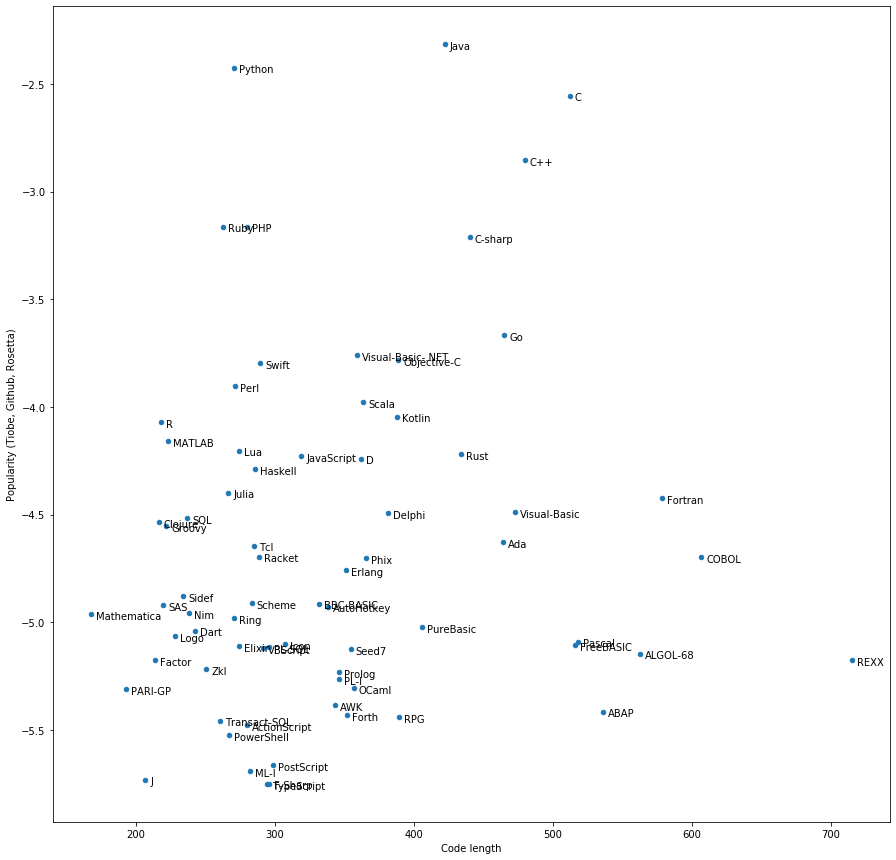

In [85]:
fig, ax = plt.subplots()
df.plot('Code length', 'Popularity (Tiobe, Github, Rosetta)', kind='scatter', ax=ax, figsize=(15, 15))

for k, v in df.iterrows():
    ax.annotate(k, v, xytext=(5,-5), textcoords='offset points')

# Hardest problems

In [86]:
pd.np.exp(all_votes).mean(level=0).sort_values('measure', ascending=False).head(10)

,measure
task,
Stable-marriage-problem,1189.479849
Zebra-puzzle,1001.772000
Maze-solving,839.074897
Arithmetic-evaluation,801.756176
Sudoku,800.007110
Chat-server,799.308157
Calendar,743.898418
Update-a-configuration-file,741.665156
Solve-a-Hidato-puzzle,718.412060
